In [5]:
import os
import csv
import numpy as np
import pickle
import cv2
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split


# Read the csv
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
print("The csv file has been loaded.")
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

images = []
measurements = []
correction = 0.2
num_lines = len(lines)
def generator(lines, batch_size=32):
    
    while 1: # Loop forever so the generator never terminates
        random.shuffle(lines)
        for offset in range(0, num_lines, batch_size):
            batch_samples = lines[offset:offset+batch_size]
            augmented_images =[]
            augmented_measurements =[]
            for batch_sample in batch_samples:
                    for i in range(3):
                        source_path = batch_sample[i]
                        filename = source_path.split('IMG')[-1]
                        current_path = './data/IMG' + filename
                        image = cv2.imread(current_path)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        image = image[50:140,:,:] # 90*320*3
                        image = cv2.resize(image, (160,45))# 45*160*3
                        measurement = float(batch_sample[3])
                        if i==1:
                            measurement+= correction
                        elif i==2:
                            measurement-= correction
                        augmented_images.append(image)
                        augmented_measurements.append(measurement)
                        augmented_images.append(cv2.flip(image,1))
                        augmented_measurements.append(measurement* -1.0)
            # trim image to only see section with road
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements) 
            yield sklearn.utils.shuffle(X_train, y_train)

The csv file has been loaded.


C:\Users\Hiroyuki\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu", strides=(2, 2))`
  from ipykernel import kernelapp as app
C:\Users\Hiroyuki\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  app.launch_new_instance()
C:\Users\Hiroyuki\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
C:\Users\Hiroyuki\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 45, 160, 3)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 78, 64)        4864      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 37, 36)         57636     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 17, 48)         43248     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 15, 64)         27712     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 15, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 960)               0         
__________

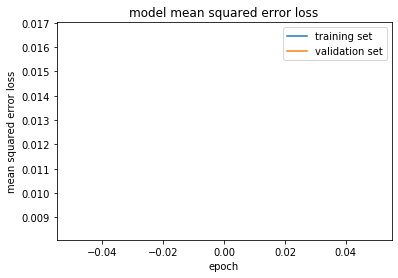

In [6]:
# Set our batch size
batch_size=32

# compile and train the model using the generator function

train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, MaxPooling2D, Dropout

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x:x/127.5-1.0, input_shape =(45,160,3)))
model.add(Conv2D(64, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='relu'))
#model.add(Conv2D(64, 3, 1, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.summary()

model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator,
            steps_per_epoch=math.ceil(len(train_samples)/batch_size),
            validation_data=validation_generator,
            validation_steps=math.ceil(len(validation_samples)/batch_size),
            epochs=1, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
model.save('model.h5')

In [ ]:
%run -i drive.py model.h5

In [26]:
import subprocess
subprocess.run(['jupyter', 'nbconvert', '--to', 'python', 'test_190901-Copy5.ipynb'])

CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'python', 'test_190901-Copy5.ipynb'], returncode=0)